In [9]:
from firedrake import *
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [10]:
mesh = UnitSquareMesh(40, 40, quadrilateral=True)

V = FunctionSpace(mesh, "DG", 1)
W = VectorFunctionSpace(mesh, "CG", 1)

x, y = SpatialCoordinate(mesh)

velocity = as_vector(( (0.5 - y ), ( x - 0.5) ))
u = Function(W).interpolate(velocity)


bell_r0 = 0.15; bell_x0 = 0.25; bell_y0 = 0.5
cone_r0 = 0.15; cone_x0 = 0.5; cone_y0 = 0.25
cyl_r0 = 0.15; cyl_x0 = 0.5; cyl_y0 = 0.75
slot_left = 0.475; slot_right = 0.525; slot_top = 0.85

bell = 0.25*(1+cos(math.pi*min_value(sqrt(pow(x-bell_x0, 2) + pow(y-bell_y0, 2))/bell_r0, 1.0)))
cone = 1.0 - min_value(sqrt(pow(x-cone_x0, 2) + pow(y-cone_y0, 2))/cyl_r0, 1.0)
slot_cyl = conditional(sqrt(pow(x-cyl_x0, 2) + pow(y-cyl_y0, 2)) < cyl_r0,
             conditional(And(And(x > slot_left, x < slot_right), y < slot_top),
               0.0, 1.0), 0.0)



UFL:WARNING Discontinuous Lagrange element requested on quadrilateral, creating DQ element.


In [11]:

q = Function(V).interpolate(1.0 + bell + cone + slot_cyl)
q_init = Function(V).assign(q)

qs = []
T = 2*math.pi
dt = T/1200
dtc = Constant(dt)
q_in = Constant(1.0)

dq_trial = TrialFunction(V)
phi = TestFunction(V)
a = phi*dq_trial*dx

n = FacetNormal(mesh)
un = 0.5*(dot(u, n) + abs(dot(u, n)))

L1 = dtc*(q*div(phi*u)*dx
          - conditional(dot(u, n) < 0, phi*dot(u, n)*q_in, 0.0)*ds
          - conditional(dot(u, n) > 0, phi*dot(u, n)*q, 0.0)*ds
          - (phi('+') - phi('-'))*(un('+')*q('+') - un('-')*q('-'))*dS)

q1 = Function(V); q2 = Function(V)
L2 = replace(L1, {q: q1}); L3 = replace(L1, {q: q2})


dq = Function(V)

In [12]:
params = {'ksp_type': 'preonly', 'pc_type': 'bjacobi', 'sub_pc_type': 'ilu'}
prob1 = LinearVariationalProblem(a, L1, dq)
solv1 = LinearVariationalSolver(prob1, solver_parameters=params)
prob2 = LinearVariationalProblem(a, L2, dq)
solv2 = LinearVariationalSolver(prob2, solver_parameters=params)
prob3 = LinearVariationalProblem(a, L3, dq)
solv3 = LinearVariationalSolver(prob3, solver_parameters=params)


In [13]:

t = 0.0
step = 0
output_freq = 20



#apply the bad limiter
DG0 = FunctionSpace(mesh, "DG", 0)
qbar = Function(DG0)



if step % output_freq == 0:
    qs.append(q.copy(deepcopy=True))
    print("t=", t)
qbar.project(q)
q.project(qbar)
print(q.dat.data.max())


t= 0.0
1.9999999999999996


In [6]:

while t < T - 0.5*dt:
    solv1.solve()
    q.assign(q + dq)
    qbar.project(q)
    q.project(qbar)

    #solv2.solve()
    #q2.assign(0.75*q + 0.25*(q1 + dq))

    #solv3.solve()
    #q.assign((1.0/3.0)*q + (2.0/3.0)*(q2 + dq))

    print(q.dat.data.max())
    step += 1
    t += dt

    if step % output_freq == 0:
        qs.append(q.copy(deepcopy=True))
        print("t=", t)



1.9999999999999987
1.9999999999999971
1.9999999999999964
1.999999999999995
1.9999995746283648
1.9999975642505592
1.9999918629348405
1.9999792863161092
1.99995550473874
1.999915029112057
1.999851238710976
1.9997564417289315
1.999621960766671
1.999438236642031
1.999194944953008
1.9988811207375288
1.998485287364464
1.9979955864759502
1.9973999063936339
1.996686006912315
t= 0.10471975511965971
1.9958416388434834
1.9948546570473251
1.9937131260125853
1.9924054173161723
1.990920298524605
1.9892470132927311
1.9873753525763043
1.9852957170082093
1.9829991705970327
1.9804774859945515
1.9777231816484446
1.974729551210591
1.9714906856119834
1.9680014882444596
1.9642576837088435
1.9602558206002638
1.9559932688055646
1.9520267427860942
1.9498609044077608
1.9474377310247746
t= 0.2094395102393196
1.9447621742003927
1.9418395021395793
1.938675330942694
1.9352756491318122
1.9316468358215968
1.9277956729132188
1.9248840158807465
1.9231575744565998
1.9211686015766818
1.9189252869919335
1.9164359349231366

0.19344199497569475


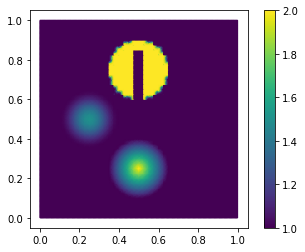

In [7]:

L2_err = sqrt(assemble((q - q_init)*(q - q_init)*dx))
L2_init = sqrt(assemble(q_init*q_init*dx))
print(L2_err/L2_init)

nsp = 16
fn_plotter = FunctionPlotter(mesh, num_sample_points=nsp)

fig, axes = plt.subplots()
axes.set_aspect('equal')
colors = tripcolor(q_init, num_sample_points=nsp, vmin=1, vmax=2, axes=axes)
fig.colorbar(colors)



In [8]:
def animate(q):
    colors.set_array(fn_plotter(q))

interval = 1e3 * output_freq * dt
animation = FuncAnimation(fig, animate, frames=qs, interval=interval)

In [14]:
try:
    animation.save("DG1_euler.mp4", writer="ffmpeg")
except:
    print("Failed to write movie! Try installing `ffmpeg`.")